In [1]:
!pip install pickle-compat

In [2]:
import pickle_compat

pickle_compat.patch()

In [3]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import os,random
import tensorflow as tf
#os.environ["KERAS_BACKEND"] = "theano"
os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(1)
import numpy as np
#import theano as th
#import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras


In [4]:
# Load the dataset ...
#  You will need to seperately download or generate this file
Xd = pickle.load(open(r"C:\Users\Sanjna\Desktop\5th sem\mini project\RML2016.10a_dict.pkl",'rb'))
snrs,mods = list(map((lambda j: sorted(list(set(map((lambda x: x[j]), Xd.keys() ) ) ) ) ), [1,0]))
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [5]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = n_examples * 0.5
train_idx = np.random.choice(range(0,n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot (list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot (list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [6]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


In [7]:

# Build VT-CNN2 Neural Net model using Keras primitives -- 
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
#model.add(Convolution2D(256, 1, 3, activation="relu", name="conv1", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
#model.add(Convolution2D(80, 2, 3, activation="relu", name="conv2", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( len(classes), kernel_initializer='he_normal', name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='Adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 1, 6, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 6, 128)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 10, 128)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 10, 128)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense1 (Dense)               (None, 256)               3

In [8]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

In [9]:

# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    #show_accuracy=False,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 2.26877, saving model to convmodrecnets_CNN2_0.5.wts.h5
108/108 - 4s - loss: 2.3459 - val_loss: 2.2688
Epoch 2/100

Epoch 00002: val_loss improved from 2.26877 to 2.24003, saving model to convmodrecnets_CNN2_0.5.wts.h5
108/108 - 4s - loss: 2.2618 - val_loss: 2.2400
Epoch 3/100

Epoch 00003: val_loss improved from 2.24003 to 2.22810, saving model to convmodrecnets_CNN2_0.5.wts.h5
108/108 - 4s - loss: 2.2462 - val_loss: 2.2281
Epoch 4/100

Epoch 00004: val_loss improved from 2.22810 to 2.21416, saving model to convmodrecnets_CNN2_0.5.wts.h5
108/108 - 4s - loss: 2.2331 - val_loss: 2.2142
Epoch 5/100

Epoch 00005: val_loss improved from 2.21416 to 2.19778, saving model to convmodrecnets_CNN2_0.5.wts.h5
108/108 - 7s - loss: 2.2204 - val_loss: 2.1978
Epoch 6/100

Epoch 00006: val_loss improved from 2.19778 to 2.18071, saving model to convmodrecnets_CNN2_0.5.wts.h5
108/108 - 6s - loss: 2.2051 - val_loss: 2.1807
Epoch 7/100

Epoch 00007: 

Epoch 54/100

Epoch 00054: val_loss did not improve from 1.96210
108/108 - 6s - loss: 2.0177 - val_loss: 1.9630
Epoch 55/100

Epoch 00055: val_loss did not improve from 1.96210
108/108 - 6s - loss: 2.0154 - val_loss: 1.9642
Epoch 56/100

Epoch 00056: val_loss did not improve from 1.96210
108/108 - 6s - loss: 2.0147 - val_loss: 1.9647
Epoch 00056: early stopping


In [10]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print(score)

1.962101936340332


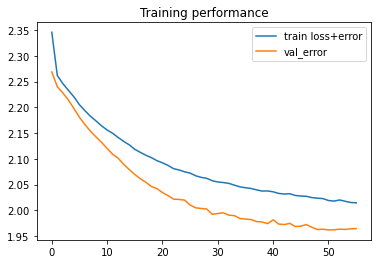

In [11]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [12]:

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

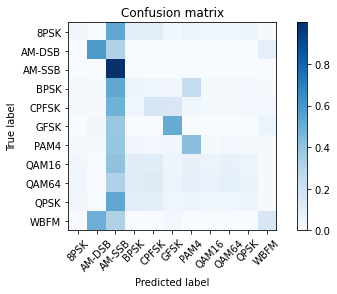

In [13]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

Overall Accuracy:  0.0929551692589204
Overall Accuracy:  0.09100817438692098
Overall Accuracy:  0.09153400868306802
Overall Accuracy:  0.08751353302057019
Overall Accuracy:  0.09662716499544212
Overall Accuracy:  0.10165274569042118
Overall Accuracy:  0.14348704758405292
Overall Accuracy:  0.23955278592375367
Overall Accuracy:  0.3399260628465804
Overall Accuracy:  0.3777213352685051
Overall Accuracy:  0.4
Overall Accuracy:  0.39967284623773175
Overall Accuracy:  0.40216593245227605
Overall Accuracy:  0.41064981949458484
Overall Accuracy:  0.4075743913435528
Overall Accuracy:  0.39672131147540984
Overall Accuracy:  0.3910917979359044
Overall Accuracy:  0.40302638863258905
Overall Accuracy:  0.4
Overall Accuracy:  0.4108010801080108


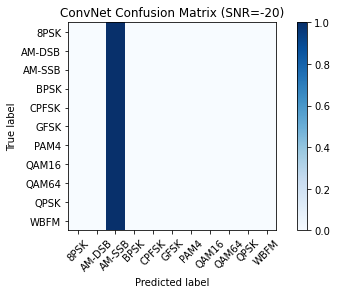

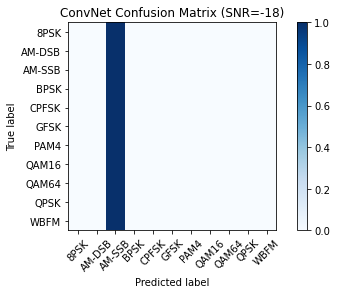

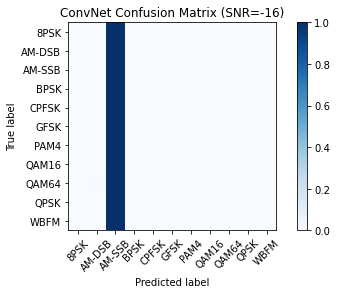

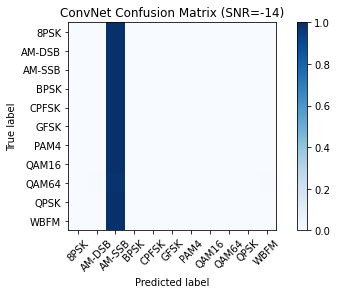

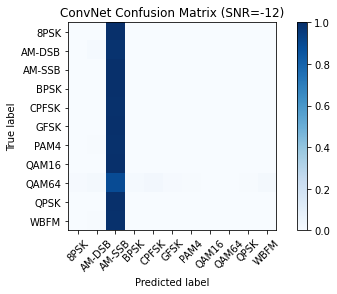

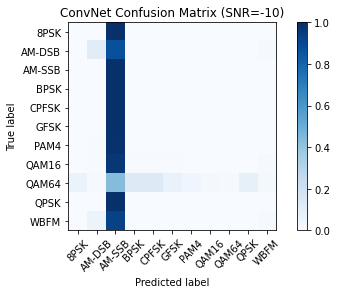

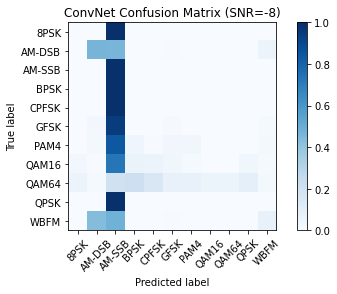

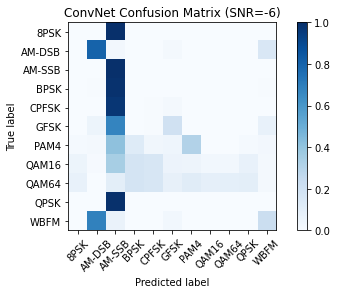

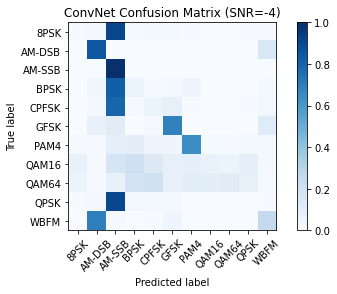

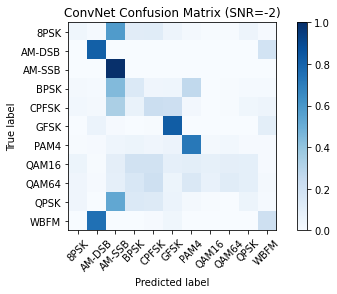

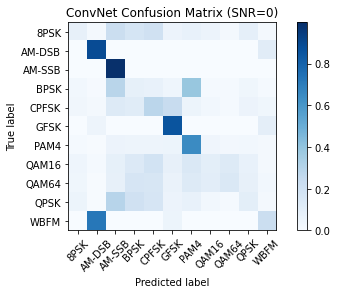

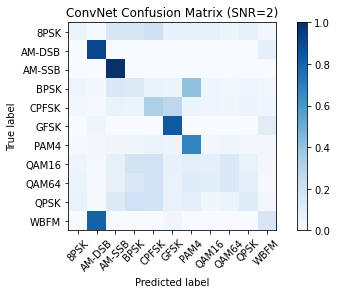

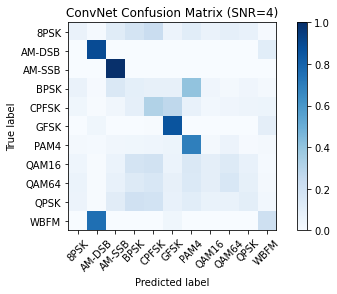

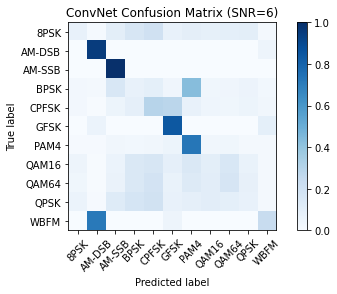

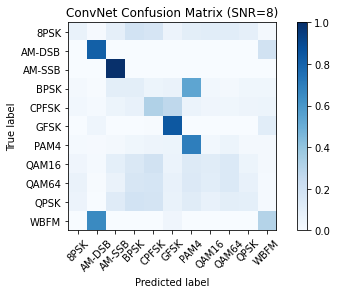

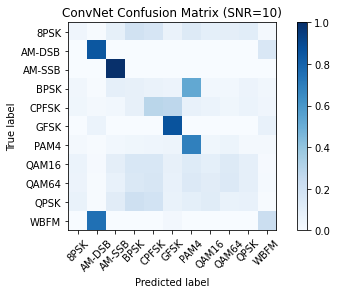

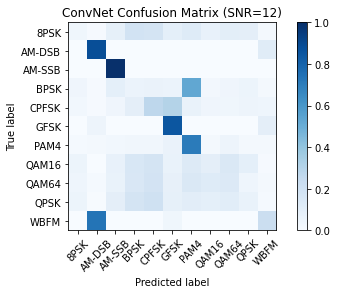

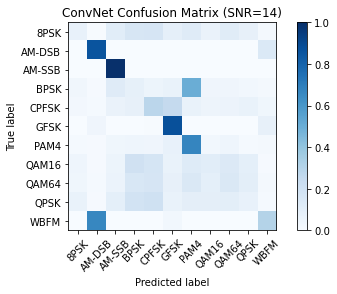

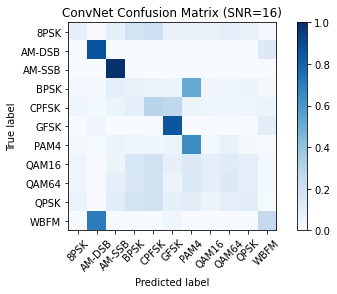

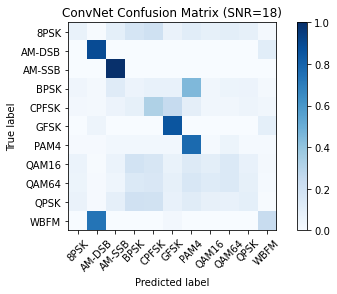

In [14]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ('Overall Accuracy: ', cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

In [15]:
# Save results to a pickle file for plotting later
print(acc)
fd = open('results_cnn2_d0.5.dat','wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )
# Save results to a pickle file for plotting later
print(acc)
fd = open('results_cnn2_d0.5.dat','wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

{-20: 0.0929551692589204, -18: 0.09100817438692098, -16: 0.09153400868306802, -14: 0.08751353302057019, -12: 0.09662716499544212, -10: 0.10165274569042118, -8: 0.14348704758405292, -6: 0.23955278592375367, -4: 0.3399260628465804, -2: 0.3777213352685051, 0: 0.4, 2: 0.39967284623773175, 4: 0.40216593245227605, 6: 0.41064981949458484, 8: 0.4075743913435528, 10: 0.39672131147540984, 12: 0.3910917979359044, 14: 0.40302638863258905, 16: 0.4, 18: 0.4108010801080108}
{-20: 0.0929551692589204, -18: 0.09100817438692098, -16: 0.09153400868306802, -14: 0.08751353302057019, -12: 0.09662716499544212, -10: 0.10165274569042118, -8: 0.14348704758405292, -6: 0.23955278592375367, -4: 0.3399260628465804, -2: 0.3777213352685051, 0: 0.4, 2: 0.39967284623773175, 4: 0.40216593245227605, 6: 0.41064981949458484, 8: 0.4075743913435528, 10: 0.39672131147540984, 12: 0.3910917979359044, 14: 0.40302638863258905, 16: 0.4, 18: 0.4108010801080108}


Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

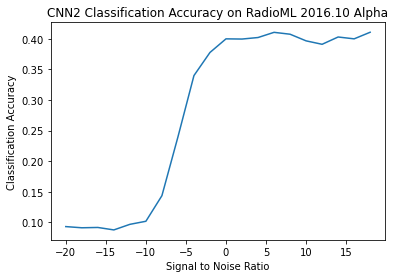

In [16]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")

In [19]:
model.save(r'C:\Users\Sanjna\Desktop\5th sem\mini project\review3')